# Herschel Stripe 82 master catalogue
## Preparation of Red Cluster Sequence Lensing Survey (RCSLenS) data

This catalogue comes from `dmu0_RCSLenS`.

In the catalogue, we keep:

- The `id` as unique object identifier;
- The position;
- The g, r, i, z, y auto magnitudes.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-20 21:21:58.071622


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "rcs_ra"
DEC_COL = "rcs_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "id": "rcs_id",
        "ALPHA_J2000": "rcs_ra",
        "DELTA_J2000": "rcs_dec",
        "CLASS_STAR": "rcs_stellarity",
        "MAG_g": "m_megacam_g",
        "MAGERR_g": "merr_megacam_g",
        "MAG_r": "m_megacam_r",
        "MAGERR_r": "merr_megacam_r",        
        "MAG_i": "m_megacam_i",
        "MAGERR_i": "merr_megacam_i",
        "MAG_z": "m_megacam_z",
        "MAGERR_z": "merr_megacam_z",
        "MAG_y": "m_megacam_y",
        "MAGERR_y": "merr_megacam_y"    
    })


catalogue = Table.read("../../dmu0/dmu0_RCSLenS/data/RCSLenS_Herschel-Stripe-82.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])

           
        # Remove missing values (-99, 99?) and extreme magnitudes (see above).
        mask = ((catalogue[col] < 0.) 
                | (catalogue[col] > 80.)
                | (catalogue[errcol] < 0.)
               | (catalogue[errcol] > 80.))
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan       
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        

        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/herschelhelp_internal/herschelhelp_internal/utils.py:39: RuntimeWarning: overflow encountered in power
  fluxes = 10 ** ((8.9 - magnitudes)/2.5)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:43: RuntimeWarning: invalid value encountered in multiply
  errors = np.log(10)/2.5 * fluxes * errors_on_magnitudes
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [6]:
catalogue[:10].show_in_notebook()

idx,rcs_id,rcs_ra,rcs_dec,rcs_stellarity,m_megacam_g,merr_megacam_g,m_megacam_r,merr_megacam_r,m_megacam_i,merr_megacam_i,m_megacam_z,merr_megacam_z,m_megacam_y,merr_megacam_y,f_megacam_g,ferr_megacam_g,flag_megacam_g,f_megacam_r,ferr_megacam_r,flag_megacam_r,f_megacam_i,ferr_megacam_i,flag_megacam_i,f_megacam_z,ferr_megacam_z,flag_megacam_z,f_megacam_y,ferr_megacam_y,flag_megacam_y
0,CDE0047A3_077984,16.1351981,2.5e-06,0.54,25.2743,0.108719,24.905,0.0926732,nan,nan,nan,nan,nan,nan,0.28202,0.0282398,False,0.396278,0.0338243,False,inf,-inf,False,9.12009e-31,8.31591e-29,False,9.12009e-31,8.31591e-29,False
1,CDE0047A3_077986,15.4374616,5.15e-05,0.09,24.2994,0.0516489,23.9391,0.0437929,nan,nan,22.6384,0.048401,23.3406,0.0527754,0.692213,0.0329288,False,0.964628,0.038908,False,inf,-inf,False,3.19625,0.142485,False,1.67402,0.0813706,False
2,CDE0047A3_077987,15.2644207,7.17e-05,0.11,24.5467,0.0537348,24.2836,0.0486367,nan,nan,23.8402,0.10472,24.0894,0.081859,0.551214,0.0272804,False,0.70236,0.031463,False,inf,-inf,False,1.05662,0.101912,False,0.839924,0.063326,False
3,CDE0047A3_077989,16.1003226,0.0001671,0.69,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,inf,nan,False,inf,nan,False,inf,-inf,False,inf,nan,False,inf,nan,False
4,CDE0047A3_077990,15.9770866,0.0001518,0.52,25.1028,0.102389,25.4661,0.149545,nan,nan,nan,nan,nan,nan,0.330278,0.0311465,False,0.236352,0.0325542,False,inf,-inf,False,9.12009e-31,8.31591e-29,False,9.12009e-31,8.31591e-29,False
5,CDE0047A3_077991,15.9379707,0.0001536,0.74,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,inf,nan,False,inf,nan,False,inf,-inf,False,inf,nan,False,inf,nan,False
6,CDE0047A3_077992,15.8770355,0.0001274,0.09,23.4706,0.0301724,23.1875,0.0263398,nan,nan,22.2164,0.0366639,22.3214,0.0238512,1.48511,0.041271,False,1.92752,0.0467614,False,inf,-inf,False,4.71455,0.159204,False,4.27996,0.0940213,False
7,CDE0047A3_077993,15.4400819,0.0001582,0.44,24.8637,0.0719446,24.1148,0.0463704,nan,nan,nan,nan,23.9767,0.0834188,0.411642,0.0272768,False,0.820503,0.0350426,False,inf,-inf,False,9.12009e-31,8.31591e-29,False,0.931794,0.0715912,False
8,CDE0047A3_077994,15.8648352,0.0001423,0.61,25.5578,0.14113,24.8876,0.0947058,nan,nan,23.7532,0.121701,24.6312,0.158448,0.21721,0.0282342,False,0.40268,0.0351247,False,inf,-inf,False,1.14477,0.128319,False,0.509941,0.0744187,False
9,CDE0047A3_077996,15.8504484,0.0001203,0.55,25.4212,0.132684,24.7199,0.0870816,nan,nan,23.8129,0.132467,nan,nan,0.246332,0.0301033,False,0.469937,0.0376914,False,inf,-inf,False,1.08353,0.132197,False,9.12009e-31,8.31591e-29,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ["merr_megacam_g","merr_megacam_r","merr_megacam_i","merr_megacam_z","merr_megacam_y"]
FLAG_NAME = 'megacam_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 13515631 sources.
The cleaned catalogue has 13137406 sources (378225 removed).
The cleaned catalogue has 371540 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

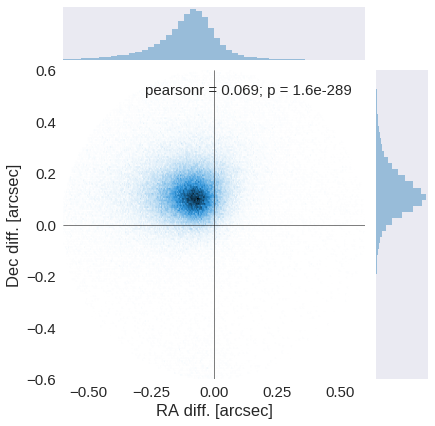

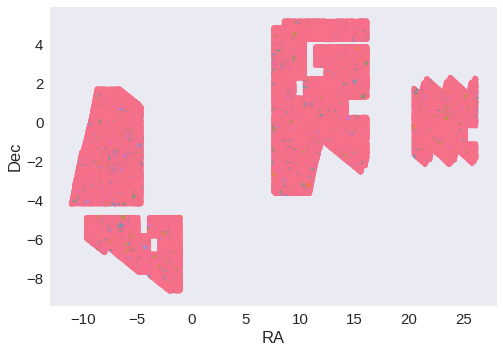

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.0935626064688222 arcsec
Dec correction: -0.11601334717702416 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

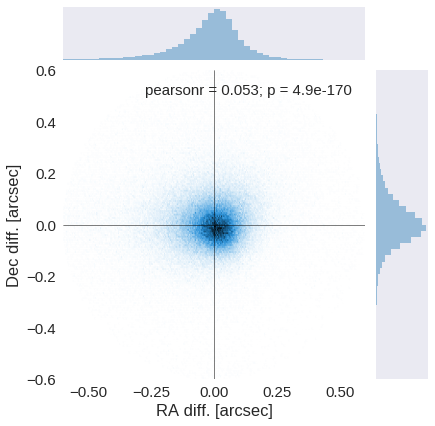

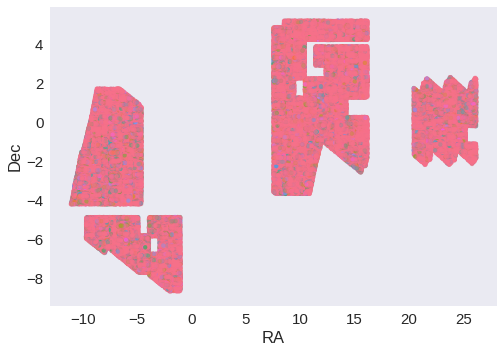

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "rcs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

307433 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/RCSLenS.fits".format(OUT_DIR), overwrite=True)